In [1]:
# ================================================
# 1. Importar librerías necesarias
# ================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from anfis import ANFIS, predict
from membership import membershipfunction
from joblib import dump
from skfuzzy import gaussmf
import os


In [2]:
# ================================================
# 2. Cargar datasets desde CSVs (carpeta data/)
# ================================================
# - Entrenamiento: datos reales (70%)
# - Validación: datos reales (30%)
# - Sintéticos: generados con GMM filtrado

df_train = pd.read_csv("data/datos_reales_entrenamiento.csv")
df_test  = pd.read_csv("data/datos_reales_validacion.csv")
df_synth = pd.read_csv("data/datos_sinteticos_filtrados.csv")

In [3]:
# ================================================
# 3. Separar inputs (X) y output (y)
# ================================================
X_train_real = df_train[['tiempo', 'voltaje', 'catalizador']].values
y_train_real = df_train[['hidrogeno']].values

X_test_real = df_test[['tiempo', 'voltaje', 'catalizador']].values
y_test_real = df_test[['hidrogeno']].values

X_synth = df_synth[['tiempo', 'voltaje', 'catalizador']].values
y_synth = df_synth[['hidrogeno']].values


In [4]:
# ================================================
# 4. Normalizar datos con escaladores basados SOLO en el 70%
# ================================================
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train_real)
y_train_scaled = scaler_y.fit_transform(y_train_real)

X_test_scaled = scaler_X.transform(X_test_real)
y_test_scaled = scaler_y.transform(y_test_real)

X_synth_scaled = scaler_X.transform(X_synth)
y_synth_scaled = scaler_y.transform(y_synth)


In [5]:
# ================================================
# 5. Combinar datos reales de entrenamiento con los sintéticos
# ================================================
X_augmented = np.vstack((X_train_scaled, X_synth_scaled))
y_augmented = np.vstack((y_train_scaled, y_synth_scaled))

print("Tamaño del conjunto de entrenamiento aumentado:", X_augmented.shape)

Tamaño del conjunto de entrenamiento aumentado: (695, 3)


In [6]:
# ================================================
# 6. Definir funciones de pertenencia para ANFIS (en espacio normalizado)
# ================================================

def escalar_valor(valor, columna, scaler):
    min_val = scaler.data_min_[columna]
    max_val = scaler.data_max_[columna]
    return (valor - min_val) / (max_val - min_val)

def escalar_array(valores, columna, scaler):
    min_val = scaler.data_min_[columna]
    max_val = scaler.data_max_[columna]
    return (valores - min_val) / (max_val - min_val)

# Escalar valores[0,1]
# columna 0 = tiempo, columna 1 = voltaje, columna 2 = catalizador
mu_t = [escalar_valor(v, 0, scaler_X) for v in [10, 20, 30]]             # tiempo: corto, medio, largo
mu_v = [escalar_valor(v, 1, scaler_X) for v in [2.5, 2.75, 2.95]]        # voltaje: bajo, medio, alto
mu_c = [escalar_valor(v, 2, scaler_X) for v in [5, 10, 15]]              # catalizador: bajo, medio, alto

mf = [
    [['gaussmf', {'mean': mu_t[0], 'sigma': 0.20}],
     ['gaussmf', {'mean': mu_t[1], 'sigma': 0.20}],
     ['gaussmf', {'mean': mu_t[2], 'sigma': 0.20}]],

    [['gaussmf', {'mean': mu_v[0], 'sigma': 0.12}],
     ['gaussmf', {'mean': mu_v[1], 'sigma': 0.12}],
     ['gaussmf', {'mean': mu_v[2], 'sigma': 0.12}]],

    [['gaussmf', {'mean': mu_c[0], 'sigma': 0.20}],
     ['gaussmf', {'mean': mu_c[1], 'sigma': 0.20}],
     ['gaussmf', {'mean': mu_c[2], 'sigma': 0.20}]]
]

mfc = membershipfunction.MemFuncs(mf)

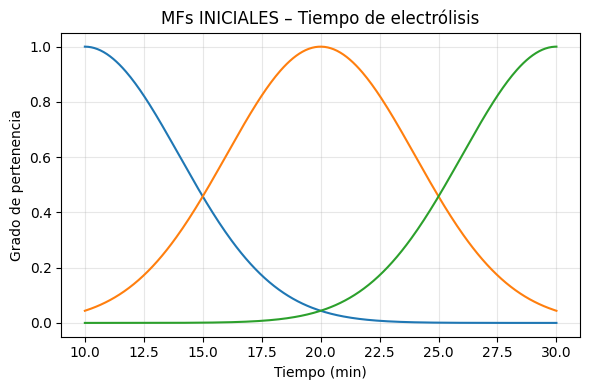

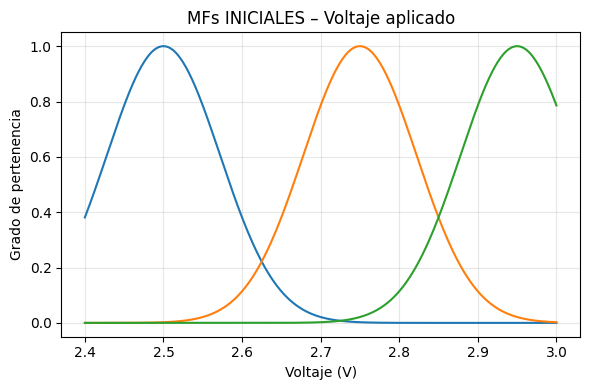

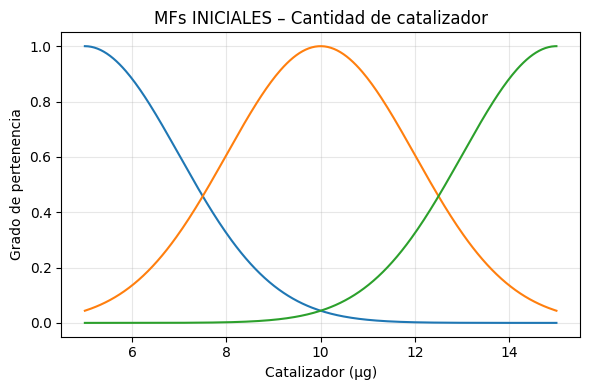

In [7]:
os.makedirs("Images", exist_ok=True)

rango_t = np.linspace(10, 30, 300)    # Tiempo (min)
rango_v = np.linspace(2.4, 3.0, 300)  # Voltaje (V)
rango_c = np.linspace(5, 15, 300)     # Catalizador (µg)

# ----- Tiempo: MFs iniciales -----
plt.figure(figsize=(6, 4))
for mf_def in mfc.MFList[0]:
    y = gaussmf(escalar_array(rango_t, 0, scaler_X), **mf_def[1])
    plt.plot(rango_t, y)
plt.title("MFs INICIALES – Tiempo de electrólisis")
plt.xlabel("Tiempo (min)")
plt.ylabel("Grado de pertenencia")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("Images/MF_inicial_tiempo.png", dpi=300)
plt.show()

# ----- Voltaje: MFs iniciales -----
plt.figure(figsize=(6, 4))
for mf_def in mfc.MFList[1]:
    y = gaussmf(escalar_array(rango_v, 1, scaler_X), **mf_def[1])
    plt.plot(rango_v, y)
plt.title("MFs INICIALES – Voltaje aplicado")
plt.xlabel("Voltaje (V)")
plt.ylabel("Grado de pertenencia")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("Images/MF_inicial_voltaje.png", dpi=300)
plt.show()

# ----- Catalizador: MFs iniciales -----
plt.figure(figsize=(6, 4))
for mf_def in mfc.MFList[2]:
    y = gaussmf(escalar_array(rango_c, 2, scaler_X), **mf_def[1])
    plt.plot(rango_c, y)
plt.title("MFs INICIALES – Cantidad de catalizador")
plt.xlabel("Catalizador (µg)")
plt.ylabel("Grado de pertenencia")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("Images/MF_inicial_catalizador.png", dpi=300)
plt.show()

In [8]:
# ================================================
# 7. Entrenar el modelo ANFIS con los datos aumentados
# ================================================

anfis_model = ANFIS(X_augmented, y_augmented.flatten(), mfc)
anfis_model.trainHybridJangOffLine(epochs=30, k=0.01, initialGamma=1000)

current error: 0.9011074619839698
current error: 0.9001659466771194
current error: 0.8990333229934716
current error: 0.9009040010327516
current error: 0.897902954123613
current error: 0.8986907938204203
current error: 0.9007132562410561
current error: 0.902884021249172
current error: 0.9052222577582557
current error: 0.9074837166400164
current error: 0.9092500859406033
current error: 0.9105146172439454
current error: 0.9114426551096536
current error: 0.9121461080129255
current error: 0.9126823353027886
current error: 0.9130824111296685
current error: 0.9133660040353195
current error: 0.9135479402869959
current error: 0.91364081971499
current error: 0.9136559441447691
current error: 0.9136036080230353
current error: 0.9134931849262483
current error: 0.9133331656817115
current error: 0.9131107687219371
current error: 0.9128193944117927
current error: 0.9124535638618702
current error: 0.9120094375123693
current error: 0.9114853456132169
current error: 0.910882302932759


array([[ 0.40933631],
       [ 0.26164718],
       [ 0.68432413],
       [ 0.09547994],
       [-0.0272056 ],
       [ 0.9384349 ],
       [ 0.58793587],
       [ 0.40933631],
       [ 0.6151791 ],
       [ 0.40933631],
       [ 0.40933631],
       [ 0.40114605],
       [ 0.23431127],
       [ 0.06782832],
       [ 0.12087631],
       [ 0.54550551],
       [ 0.55811667],
       [ 0.41489302],
       [ 0.36744924],
       [ 0.68101338],
       [ 0.17666187],
       [ 0.66187565],
       [ 0.80149977],
       [ 0.66760566],
       [ 0.36421518],
       [ 0.1591925 ],
       [ 0.30349911],
       [ 0.54007175],
       [ 0.23094696],
       [ 0.56941941],
       [ 0.32468778],
       [ 0.8423327 ],
       [ 0.7272243 ],
       [ 0.65660694],
       [ 0.13993779],
       [ 0.11484992],
       [ 0.17886577],
       [ 0.64737483],
       [ 0.4666488 ],
       [ 0.51594306],
       [ 0.36545135],
       [ 0.23441049],
       [ 0.45292451],
       [ 0.66569081],
       [ 0.85688539],
       [ 0

In [9]:
# ================================================
# 8. Validar el modelo con el 30% original (no visto)
# ================================================
y_pred_scaled = predict(anfis_model, X_test_scaled)

# Desnormalizar resultados
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_real = scaler_y.inverse_transform(y_test_scaled).flatten()

rmse = np.sqrt(mean_squared_error(y_real, y_pred))
r2 = r2_score(y_real, y_pred)

print("\n=== Validación con 30% de datos reales NO vistos ===")
print(f"RMSE: {rmse:.3f}")
print(f"R²: {r2:.3f}")

print("\nValores reales vs. predichos:")
for real, pred in zip(y_real, y_pred):
    print(f"Real: {real:.2f} - Predicho: {pred:.2f}")


=== Validación con 30% de datos reales NO vistos ===
RMSE: 4.159
R²: 0.943

Valores reales vs. predichos:
Real: 79.20 - Predicho: 85.80
Real: 53.80 - Predicho: 54.31
Real: 58.80 - Predicho: 57.87
Real: 39.10 - Predicho: 38.80
Real: 34.90 - Predicho: 39.90
Real: 26.50 - Predicho: 32.33


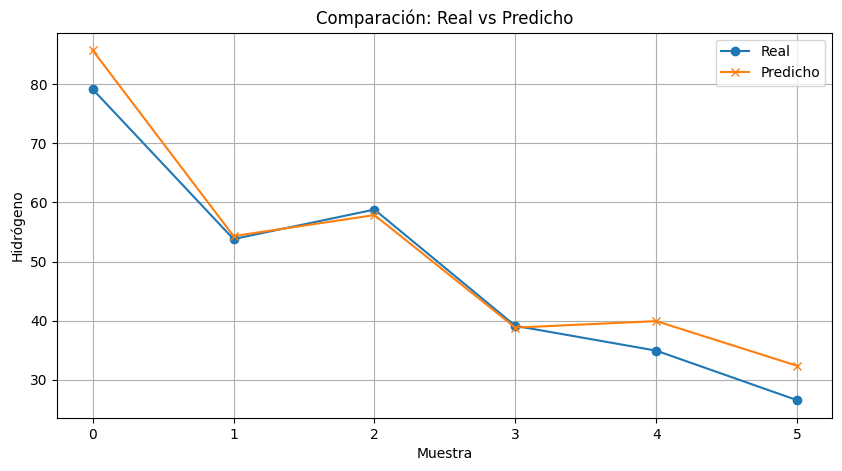

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(y_real, label='Real', marker='o')
plt.plot(y_pred, label='Predicho', marker='x')
plt.title("Comparación: Real vs Predicho")
plt.xlabel("Muestra")
plt.ylabel("Hidrógeno")
plt.legend()
plt.grid(True)
plt.show()

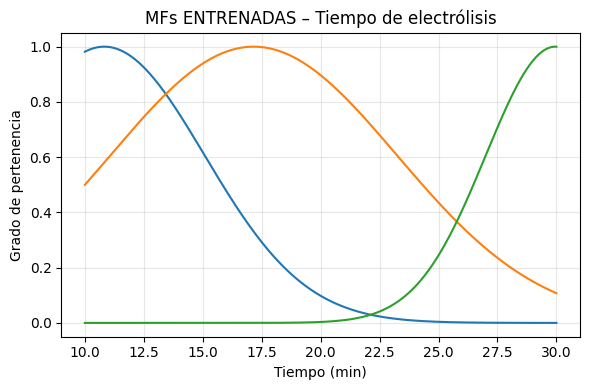

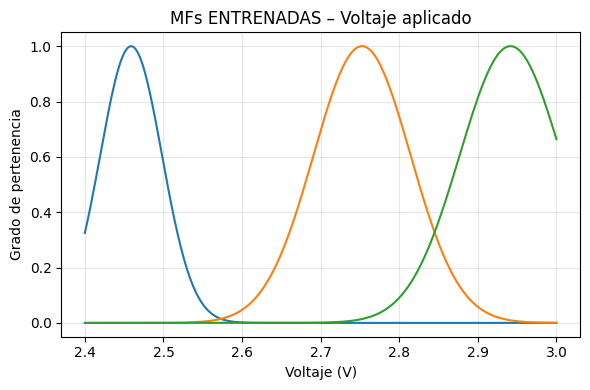

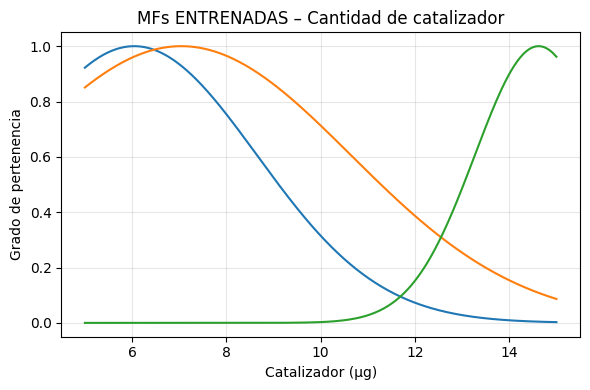

In [11]:

# ----- Tiempo: MFs entrenadas -----
plt.figure(figsize=(6, 4))
for mf_def in anfis_model.memClass.MFList[0]:
    y = gaussmf(escalar_array(rango_t, 0, scaler_X), **mf_def[1])
    plt.plot(rango_t, y)
plt.title("MFs ENTRENADAS – Tiempo de electrólisis")
plt.xlabel("Tiempo (min)")
plt.ylabel("Grado de pertenencia")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("Images/MF_entrenada_tiempo.png", dpi=300)
plt.show()

# ----- Voltaje: MFs entrenadas -----
plt.figure(figsize=(6, 4))
for mf_def in anfis_model.memClass.MFList[1]:
    y = gaussmf(escalar_array(rango_v, 1, scaler_X), **mf_def[1])
    plt.plot(rango_v, y)
plt.title("MFs ENTRENADAS – Voltaje aplicado")
plt.xlabel("Voltaje (V)")
plt.ylabel("Grado de pertenencia")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("Images/MF_entrenada_voltaje.png", dpi=300)
plt.show()

# ----- Catalizador: MFs entrenadas -----
plt.figure(figsize=(6, 4))
for mf_def in anfis_model.memClass.MFList[2]:
    y = gaussmf(escalar_array(rango_c, 2, scaler_X), **mf_def[1])
    plt.plot(rango_c, y)
plt.title("MFs ENTRENADAS – Cantidad de catalizador")
plt.xlabel("Catalizador (µg)")
plt.ylabel("Grado de pertenencia")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("Images/MF_entrenada_catalizador.png", dpi=300)
plt.show()


In [12]:
MODEL_DIR = "models"
os.makedirs(MODEL_DIR, exist_ok=True)

dump(anfis_model, os.path.join(MODEL_DIR, "anfis_model.pkl"))
dump(scaler_X,   os.path.join(MODEL_DIR, "scaler_X.pkl"))
dump(scaler_y,   os.path.join(MODEL_DIR, "scaler_y.pkl"))

print("\nModelo y escaladores guardados en /models/")
print(" - models/anfis_model.pkl")
print(" - models/scaler_X.pkl")
print(" - models/scaler_y.pkl")


Modelo y escaladores guardados en /models/
 - models/anfis_model.pkl
 - models/scaler_X.pkl
 - models/scaler_y.pkl
